In [170]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib

In [171]:
def parse_logs(xhistory, ret_time=False, funcx=None):
    values = [funcx(x) for x, _ in xhistory]
    if ret_time:
        times = [t for _, t in xhistory]
        times = [times[ind] - times[0] for ind, t in enumerate(times)]
    else:
        times = [i for i in range(len(xhistory))]
    return times, values

In [172]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 25,
          "xtick.labelsize": 15,
          "ytick.labelsize": 15,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

## Субградиент и субдифференциал

**Определение.** Вектор $g$ называется *субградиентом* функции $f$ в точке $x$, если $\forall y\in X$ выполнено

$$
f(y) \geq f(x) + \langle g, y - x \rangle \quad \quad (1)
$$

**Определение.** Множество всех субградиентов $f$ в точке $x$ будем называть *субдифференциалом* и будем обозначать как $\partial f(x)$.

### Основные свойства субдифференциала

- Если $f$ - выпуклая функция, то субдифференциал непуст и ограничен
- Если $f$ выпукла и дифференцируема в точке $x$, то $\partial f(x) = \{ \nabla f(x) \}$
- Точка $x^*$ является минимумом функции $f$ тогда и только тогда, когда $0 \in \partial f(x^*)$. В случае дифференцируемой, выпуклой $f$ это свойство сводится к $\nabla f(x^*) = 0$

### Субдифференциальное исчисление
1) $\partial \alpha f(x) = \alpha \partial f(x)$, где $\alpha \geq 0$
2) $\partial f(x) = \partial \sum_i f_i(x) = \sum_i \partial f_i(x)$
3) Если $f$ - выпукла и $h(x) = f(Ax + b)$, то $\partial h(x) = A^\top \partial f(Ax + b)$
4) Если $f_i$ - выпуклы и $f(x) = \max_{i = i..m} f_i(x)$, то $\partial f(x) = Co \cup \{ \partial f_i(x) \ | \ f_i(x) = f(x) \}$
5) Если $F(x, y)$ субдифференцируема и выпукла по совокупности переменных, то $\partial f(x) = \partial ( \inf_y F(x, y) )$, где $x \in \mathbb{R}^n, y \in \mathbb{R}^m$, то $\partial f(x) = \{ g \in \mathbb{R}^n | (g, 0) \in \partial F(x, y_{\min}) \}$

### Некоторые примеры на вычисление субдифференциалов


__Пример 1__. Рассмотрим функцию $f(x) = \sum_{i=1}^n |\langle a_i, x \rangle - b_i|$. Введем обозначения  
$$
I_-(x) = \{ i \mid \langle a_i, x \rangle - b_i < 0 \},
$$
$$
I_+(x) = \{ i \mid \langle a_i, x \rangle - b_i > 0 \},
$$  
$$
I_0(x) = \{ i \mid \langle a_i, x \rangle - b_i = 0 \}.
$$  

Тогда $\partial f(x) = \sum_{i \in I_+(x)} a_i - \sum_{i \in I_-(x)} a_i + \sum_{i \in I_0(x)} [-a_i, a_i]$.

__Пример 2__. Рассмотрим функцию $f(x) = \max_{1 \leq i \leq n} x^{(i)}$. Пусть $I(x) = \{ i: x^{(i)} = f(x) \}.$  

Тогда $\partial f(x) = \mathrm{Conv} \{ e_i \mid i \in I(x) \}.$ Для $ x = 0 $ получаем $\partial f(0) = \mathrm{Conv} \{ e_i \mid 1 \leq i \leq n \} \equiv \Delta_n$.

$e_i$ - вектор, у которого элемент с индексом $i$ равен 1, а остальные 0.

__Пример 3__. Для евклидовой нормы $f(x) = \| x \|_2$ имеют место равенства  
$$\partial f(0) = B_2^n (0, 1) = \{ x \in \mathbb{R}^n \mid \| x \|_2 \leq 1 \},$$
$$\partial f(x) = \{ x / \| x \|_2 \}, \, x \neq 0$$

__Пример 4__. Для $l_1$-нормы $f(x) = \|x\|_1 = \sum_{i=1}^n |x^{(i)}|$ получаем
$$
\partial f(0) = B_\infty(0, 1) = \left\{ x \in \mathbb{R}^n \mid \max_{1 \leq i \leq n} |x^{(i)}| \leq 1 \right\},
$$

$$
\partial f(x) = \sum_{i \in I_+(x)} e_i - \sum_{i \in I_-(x)} e_i + \sum_{i \in I_0(x)} [-e_i, e_i], \, x \neq 0,
$$

, где $I_+(x) = \{ i \mid x^{(i)} > 0 \}, \, I_-(x) = \{ i \mid x^{(i)} < 0 \}, \, \text{и } I_0(x) = \{ i \mid x^{(i)} = 0 \}$.

## Субградиентный метод

Мы решаем задачу оптимизации

$$\min_{\mathbf{x}\in\mathbb{R}^n} f(\mathbf{x})$$

Итерация субградиентного метода:

$$\mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \mathbf{g}_k,$$

где $\mathbf{g}_k$ - субградиент $f$ в точке $\mathbf{x}_k$, $\alpha_k$ - длина шага.

Особенность алгоритма:  

- Направление субградиента $- \partial f(x)$ не всегда является направление убывания фукнции, пример: $f(x) = |x_1 - x_2| + 0.2 |x_1 + x_2|$ в точке $\{1, 1\}$ в (см. Б.Т. Поляк "Введение в оптимизацию" с. 128)
- С постоянной длиной шага метод может не сходиться
- Медленная скорость сходимости. Но есть способы ускорить: проксимальный метод, ускоренный субградиентный метод, шаг Поляка

Варианты подбора шага:

* Убывающий шаг: 
    $$
    \alpha_k = \frac{\| x_0 - x^* \|}{\sqrt{k+1}}
    $$ 
    оптимален для субградиентного метода (см. Ю.Е. Нестеров "Выпуклая оптимизация" с. 177)

* Убывающий шаг с константой сильной выпуклости: 
$$
\alpha_k=\frac{2}{\mu (k+1)}
$$
, где $\mu$ - константа сильной выпуклости. См. S. Bubeck. Convex Optimization: Algorithms and Complexity.//
https://arxiv.org/abs/1405.4980. Theorem 3.9.

<!-- * $\alpha_k = \frac{\alpha_0}{k+1}$ 
* $\alpha_k = \frac{\alpha_0}{k \ln {k}}$ 
* $\alpha_k = \frac{\alpha_0}{k^\rho}$, где $\rho \in (0, 1]$ -->

* Шаг Поляка: 
$$
\alpha_k=\frac{f_k-f^*}{\|g_k\|^2}
$$
, где $f^*$ - это решение. Когда оно может быть известно? При решении СЛАУ, для многих геометрических задач. Оптимален для субградиентного метода.

* Нормированный шаг: 
$$\alpha_k=\frac{\gamma}{\|g_k\|}$$
, где $\gamma$ желаемая точность решения.

Некоторые отличия от гладкого случая:
- В качестве решения теперь берём либо **среднее** от k последних итераций либо **наименьшее** из всех итераций значение. 
- Внимание, условия остановки $\| \partial f(x) \| \leq \varepsilon$ больше не информативно.

## Реализация субградиентного метода

In [173]:
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []

    def solve(self, x0, f, gradf, tol=1e-3, max_iter=5000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while x_prev is None or np.linalg.norm(x - x_prev) > tol:
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

Шаги

In [174]:
class StepSize:
    def __call__(self, x, h, k, *args, **kwargs):
        pass

# Убывающий шаг
class SeqStepSize(StepSize):
    def __init__(self, d=1, alpha0=1, alpha_function=None):
        if alpha_function is not None:
            self.alpha_function = alpha_function
        else:
            self.alpha_function = lambda k: alpha0/(k+1)**d
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha_function(k)

# Нормированный шаг
class ScaledConstantStepSize(StepSize):
    def __init__(self, alpha0=0.5):
        self.alpha0 = alpha0

    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return self.alpha0 / np.linalg.norm(gradf(x))
    
# шаг Поляка
class PolyakStepSize(StepSize):
    def __init__(self, f_sol=0.0):
        self.f_sol = f_sol

    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return (f(x) - self.f_sol) / np.linalg.norm(gradf(x)) ** 2

## Эксперимент. Решение СЛАУ

$$f(x) = \| Ax - b \|_1$$

Для нахождения субградиента применяем правило 3 и Пример 1:
$$
\partial f(x) = \partial ( \| Ax - b \|_1 ) = \text{sign} (|Ax - b|) \partial (Ax - b) = A^\top (\text{sign} (Ax - b))
$$

In [175]:
def func_SLE_l1(A, b):
    return lambda x: np.abs(A.dot(x) - b).sum()

def subgrad_func_SLE_l1(A, b):
    return lambda x: A.T @ np.sign(A.dot(x) - b)

Значения функций на графиках будем вычислять на каждой итерации в рекордной точке для $k$-й итерации:
$$
\min_k f(x_k)
$$
Так как оценки сходимости для убывающего шага доказаны для таких точек, (см. Ю.Е. Нестеров "Выпуклая оптимизация" с. 177), а остальные версии шага монотонно-убывающие.

In [176]:
# рекордно минимальное значение на каждой итерации
def min_value_up_to_k_in_xhistory(hist_log, f):
    xs, ts = zip(*hist_log)
    fvals = np.array([f(x) for x in xs])
    min_fvals = np.minimum.accumulate(fvals)
    return list(zip(min_fvals, ts))

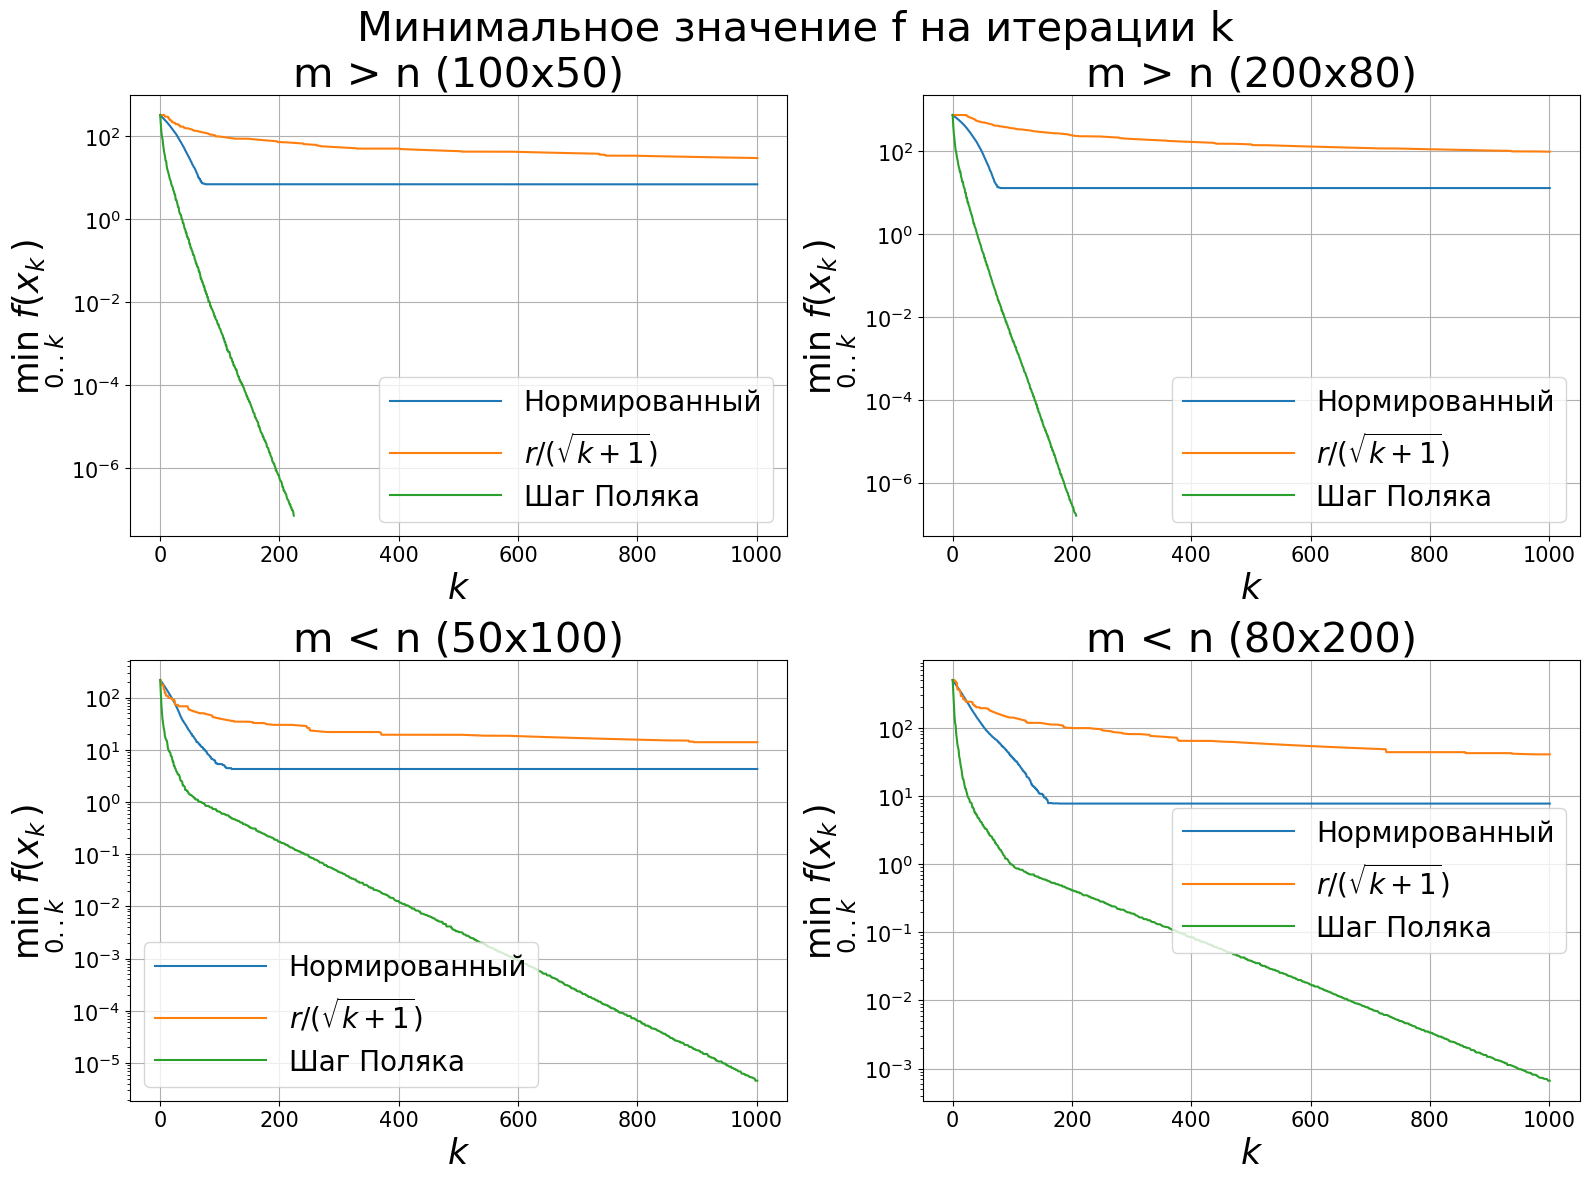

In [177]:
%matplotlib inline
np.random.seed(42)

configs = [
    {"m": 100, "n": 50, "title": "m > n (100x50)"},
    {"m": 200, "n": 80, "title": "m > n (200x80)"},
    {"m": 50, "n": 100, "title": "m < n (50x100)"},
    {"m": 80, "n": 200, "title": "m < n (80x200)"},
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, config in enumerate(configs):
    m, n = config["m"], config["n"]
    title = config["title"]

    A = np.random.randn(m, n)
    x_true = np.random.rand(n)
    b = A.dot(x_true)
    x0 = np.zeros(n)
    f_l1 = func_SLE_l1(A, b)
    subgradf_l1 = subgrad_func_SLE_l1(A, b)
    epsilon = 1e-9

    methods = [
        GradientDescent(ScaledConstantStepSize(1e-1), name=r"Нормированный"),
        GradientDescent(SeqStepSize(d=0.5, alpha0=0.1), name=r"$r / (\sqrt{k+1})$"),
        GradientDescent(PolyakStepSize(f_sol=np.abs(A.dot(x_true) - b).sum()), name=r"Шаг Поляка"),
    ]

    for method in methods:
        method.history = []
        method.solve(x0, f_l1, subgradf_l1, tol=epsilon, max_iter=1000)

    ax = axes[idx]
    funcx = lambda x: x

    for method in methods:
        xhistory = method.history
        if not xhistory: continue
        xhistory = min_value_up_to_k_in_xhistory(xhistory, f_l1)
        iters, values = parse_logs(xhistory, ret_time=False, funcx=funcx)
        ax.semilogy(iters, values, label=method.name, linewidth=1.5)

    ax.grid()
    
    ax.set_title(title)
    ax.set_ylabel(r"$\min_{0..k} \ f(x_k)$")
    ax.set_xlabel(r"$k$")
    ax.set_title(title)
    ax.legend()

title = f"Минимальное значение f на итерации k"
plt.suptitle(title, fontsize=30)
plt.tight_layout()
plt.show()

## $l_2$ решение

$$\min_x f(x) = \|Ax-b\|_2^2$$

Сравним близость к решению и скорость сходимости для гладкой и негладкой функции

In [178]:
def func_l2(A, b):
    return lambda x: np.linalg.norm(A.dot(x) - b)**2

def grad_f_l2(A, b):
    return lambda x: 2 * A.T.dot(A.dot(x) - b)

class ConstantStepSize(StepSize):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha

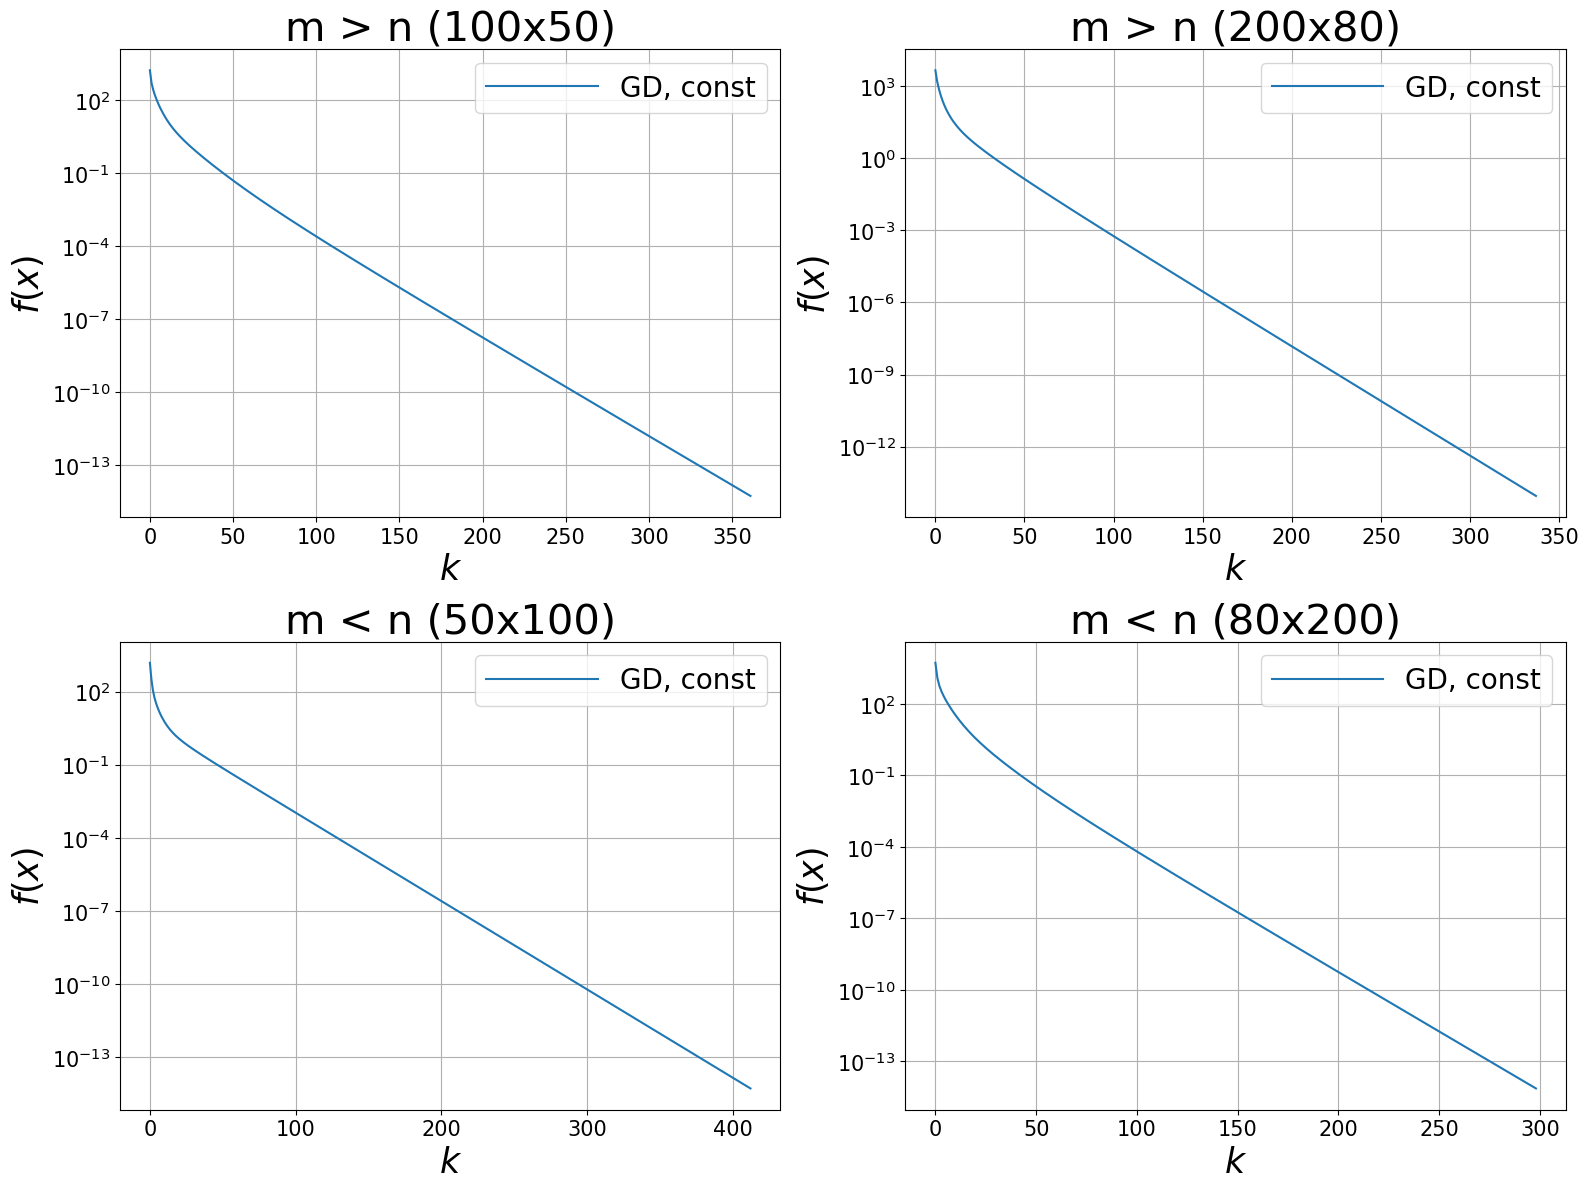

In [179]:
%matplotlib inline
np.random.seed(42)

configs = [
    {"m": 100, "n": 50, "title": "m > n (100x50)"},
    {"m": 200, "n": 80, "title": "m > n (200x80)"},
    {"m": 50, "n": 100, "title": "m < n (50x100)"},
    {"m": 80, "n": 200, "title": "m < n (80x200)"},
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, config in enumerate(configs):
    m, n = config["m"], config["n"]
    title = config["title"]

    A = np.random.randn(m, n)
    x_true = np.random.rand(n)
    b = A.dot(x_true)
    x0 = np.zeros(n)
    f_l2 = func_l2(A, b)
    gradf_l2 = grad_f_l2(A, b)
    L = 2 * np.linalg.norm(A, ord=2) ** 2
    epsilon = 1e-9

    methods = [GradientDescent(ConstantStepSize(1 / L), name="GD, const")]

    for method in methods:
        method.history = []
        method.solve(x0, f_l2, gradf_l2, tol=epsilon, max_iter=1000)

    ax = axes[idx]
    funcx = lambda x: f_l2(x)
    for method in methods:
        xhistory = method.history
        if not xhistory: continue
        iters, values = parse_logs(xhistory, ret_time=False, funcx=funcx)
        ax.semilogy(iters, values, label=method.name, linewidth=1.5)

    ax.grid()
    ax.set_ylabel(r"$f(x)$")
    ax.set_xlabel(r"$k$")
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

Посмотрим на структуру двух решений

In [180]:
np.random.seed(22)
n = 500
m = 1000
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A.dot(x_true) + np.random.randn(m)
x0 = np.ones(n)
max_iter = 1000
epsilon = 1e-9

# l1 norm SLE
f_l1 = func_SLE_l1(A, b)
subgradf_l1 = subgrad_func_SLE_l1(A, b)

# l2 norm SLE
f_l2 = func_l2(A, b)
gradf_l2 = grad_f_l2(A, b)
L = 2 * np.linalg.norm(A, ord=2) ** 2

method = GradientDescent(PolyakStepSize(f_sol=np.abs(A.dot(x_true) - b).sum()), name="Поляка")
x_l1 = method.solve(x0, f_l1, subgradf_l1, tol=epsilon, max_iter=max_iter)

method = GradientDescent(ConstantStepSize(1/L), name="Град, 1/L")
x_l2 = method.solve(x0, f_l2, gradf_l2, tol=epsilon, max_iter=max_iter)

На "своей" минимизации результат лучше как и следовало ожидать

In [181]:
print('l1: ' + str(f_l1(x_l1)), 'l2: ' + str(f_l2(x_l1)))
print('l1: ' + str(f_l1(x_l2)), 'l2: ' + str(f_l2(x_l2)))

l1: 759.4562640528397 l2: 1608.5400170286532
l1: 550.342545966757 l2: 470.68264395844534


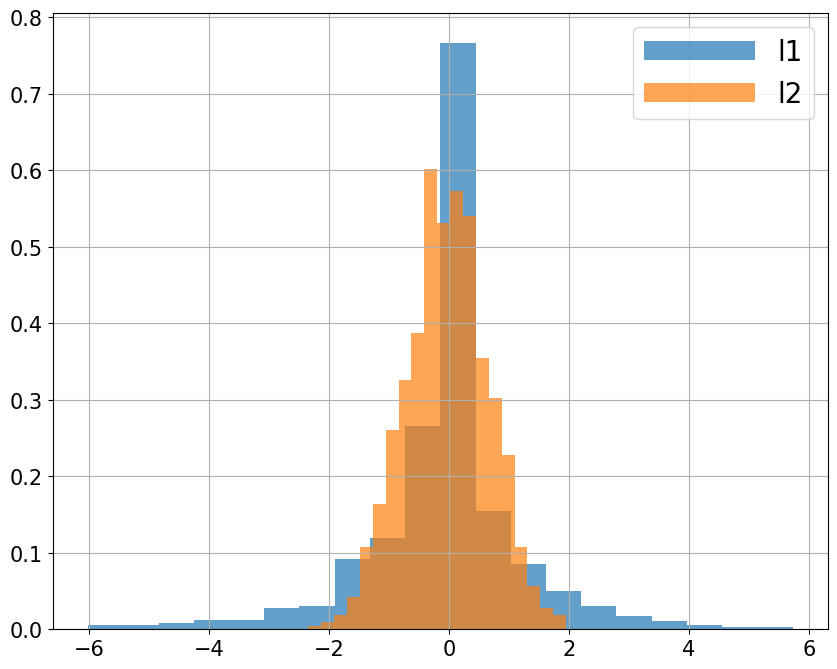

In [182]:
plt.figure(figsize=(10, 8))
plt.hist(A@x_l1-b, bins=20, label="l1", density=True, alpha=0.7)
plt.hist(A@x_l2-b, bins=20, label="l2", density=True, alpha=0.7)
plt.legend()
plt.grid()

## Эксперимент: SVM

hinge-loss function + $l_2$ регуляризатор:
$$\min _x f(x):=\frac{1}{n} \sum_{i=1}^n \max \left\{0,1-y_i x^T w_i\right\}+\frac{\lambda}{2}\|x\|_2^2$$
, где $\max(0,1-y(w^Tx))$ hinge-loss функция, $y_i$ - параметр выборки $\{ -1, +1\}$, который задаёт класс точек $\omega_i$.

In [183]:
def svm_objective(x, W, y, lam):
    margins = 1 - y * (W @ x)
    hinge = np.maximum(0.0, margins)
    loss = hinge.mean()
    reg = (lam / 2.0) * np.dot(x, x)

    return loss + reg

def svm_subgradient(x, W, y, lam):
    margins = 1 - y * (W @ x)
    active = margins > 0

    g_hinge = (-y[active, None] * W[active]).mean(axis=0) if np.any(active) else np.zeros_like(x)

    g = g_hinge + lam * x

    return g

In [184]:
rng = np.random.default_rng(42)
n=400
d=120 
noise=0.05

W_pos = rng.normal(loc=+1.0, scale=1.0, size=(n // 2, d))
W_neg = rng.normal(loc=-1.0, scale=1.0, size=(n // 2, d))
W = np.vstack([W_pos, W_neg])

y = np.hstack([np.ones(n // 2), -np.ones(n // 2)])

flip = rng.random(n) < noise
y[flip] *= -1

Функция является сильно выпуклой с константой сильной выпуклости равно $\mu = \lambda$, поэтому протестируем убывающую версию шага

$$
\alpha(k) = \frac{2}{\mu (k+1)}
$$

Так же протестируем модификации убывающего шага:

$$
\alpha(k) = \max\left(3^{-\left\lfloor\frac{k}{100}\right\rfloor}, 10^{-5}\right)
$$

Данный шаг убывает на каждой 100-й итерации, а не на каждой.

In [185]:
def alpha_function1(k):
    return max(3**(-k//100), 1e-5)

И еще одну версию:

$$
\alpha(k) = \min \{ \frac{2}{\sqrt{k+1}}, 10^{-3} \}
$$

Данный шаг улучшает стандартный убывающий тем, что "срезает" первые слишком большие шаги.

In [186]:
def alpha_function2(k):
    return min(2 / (k+1)**(0.5), 1e-3)

В соответствии с теоретическими оценками для убывающего шага с константой сильной выпуклости (см. См. S. Bubeck. Convex Optimization: Algorithms and Complexity.//
https://arxiv.org/abs/1405.4980. Theorem 3.9) на графиках динамику изменения значения функции будем проверять в усредненной точке, а не в последней:
$$
f\left(\sum_{i=1}^N \frac{2i}{N(N+1)}x_i\right)
$$

In [187]:
# Усредненное значение на каждой итерации
def mean_value_up_to_k_in_xhistory(hist_log, f):
    xs, ts = zip(*hist_log)
    xs = np.array(xs)

    N = len(xs)
    out = []

    for n in range(1, N + 1):
        k = np.arange(1, n + 1)
        weights = 2 * k / (n * (n + 1))
        x_avg = np.sum(xs[:n] * weights[:, None], axis=0)
        out.append((f(x_avg), ts[n - 1]))

    return out

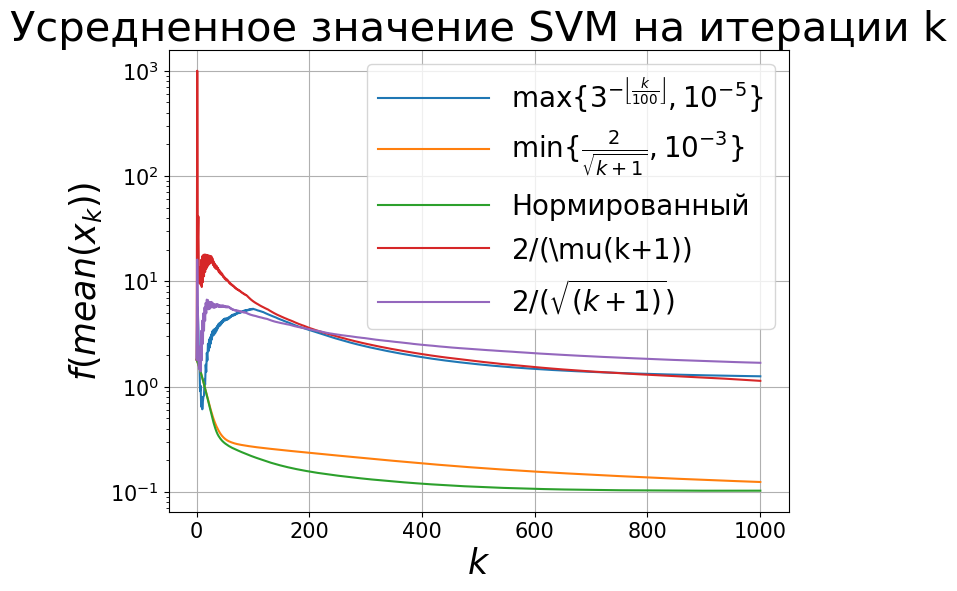

In [188]:
%matplotlib inline
lam= 0.1
epsilon = 1e-6
max_iter = 1000
x0 = rng.normal(scale=0.1, size=d)
svm_f = lambda x: svm_objective(x, W, y, lam=lam)
svm_subg = lambda x: svm_subgradient(x, W, y, lam=lam)

methods = [
    GradientDescent(SeqStepSize(alpha_function=alpha_function1), name=r"$\max \{ 3^{-\left\lfloor\frac{k}{100}\right\rfloor}, 10^{-5} \}$"),
    GradientDescent(SeqStepSize(alpha_function=alpha_function2), name=r"$\min \{ \frac{2}{\sqrt{k+1}}, 10^{-3} \}$"),
    GradientDescent(ScaledConstantStepSize(1e-2), name=r"Нормированный"),
    GradientDescent(SeqStepSize(d=1.0, alpha0=2 / lam), name=r"$2 / ($\mu(k+1)$)$"),
    GradientDescent(SeqStepSize(d=0.5, alpha0=2), name=r"$2 / (\sqrt{(k+1)})$"),
]

for method in methods:
    method.history = []
    method.solve(x0, svm_f, svm_subg, tol=epsilon, max_iter=max_iter)

fig, ax = plt.subplots(figsize=(8, 6))
funcx = lambda x: x
for method in methods:
    xhistory = method.history.copy()
    if not xhistory: continue
    xhistory = mean_value_up_to_k_in_xhistory(xhistory, svm_f)
    iters, values = parse_logs(xhistory, ret_time=False, funcx=funcx)
    ax.semilogy(iters, values, label=method.name, linewidth=1.5)

title = "Усредненное значение SVM на итерации k"
ax.grid()
ax.set_ylabel(r"$f(mean(x_k))$")
ax.set_xlabel(r"$k$")
ax.set_title(title)
ax.legend();

Так же посмотрим динамику в рекордно-минимальной точке

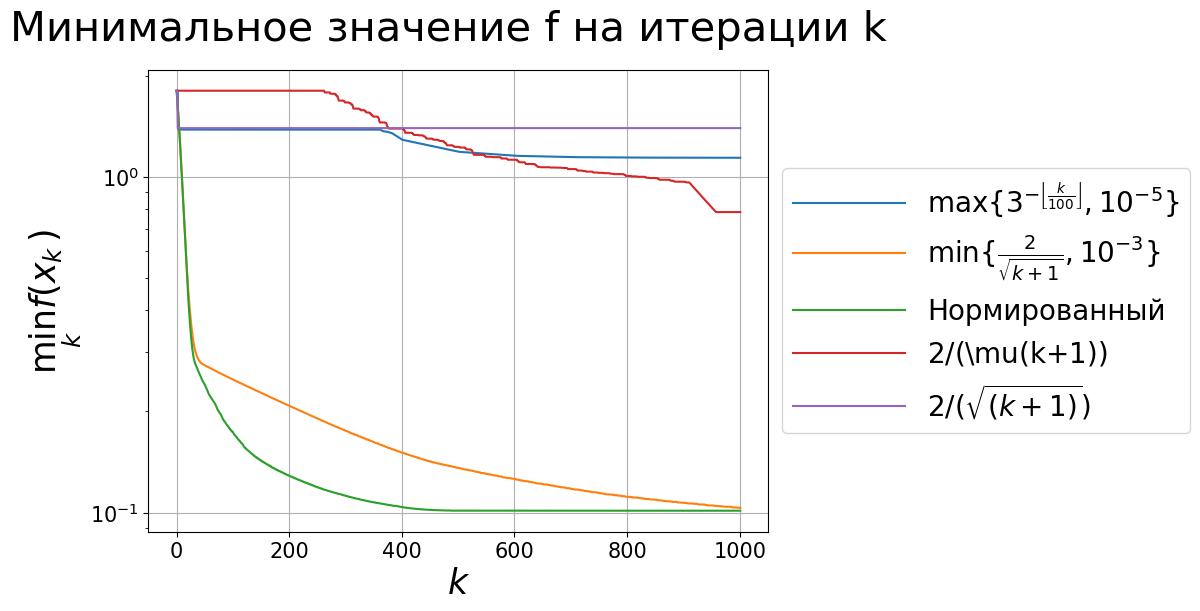

In [190]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 6))

funcx = lambda x: x
for method in methods:
    xhistory = method.history.copy()
    if not xhistory: continue
    xhistory = min_value_up_to_k_in_xhistory(xhistory, svm_f)
    iters, values = parse_logs(xhistory, ret_time=False, funcx=funcx)
    ax.semilogy(iters, values, label=method.name, linewidth=1.5)

title = "Минимальное значение f на итерации k"
ax.grid()
plt.suptitle(title, fontsize=30)
ax.set_ylabel(r"$\min_k f(x_k)$")
ax.set_xlabel(r"$k$")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));